## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

# Default to using cuda if a GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
#evice = "cpu"
torch.device(device)
print("Device set to %s" % device)

def to_cpu_tensor(tensor):
    return tensor.cpu() if device == "cuda" else tensor
        
def to_cuda_tensor(tensor):
    return tensor.cuda() if device == "cuda" else tensor

net = Net()
if device == "cuda":
    net.cuda()
print(net)

Device set to cuda
Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (dropout3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (dropout4): Dropout(p=0.4, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense_1): Linear(in_features=6400, out_features=1000, bias=True)
  (dropout5): Dropout(p=0.5, inplace=False)
  (dense_2): Linear(in_features=1000, out_features=1000, bias=True)
  (dropout6): Dropout(p=0.6, inplace=False)
  (dense_3): Linear(in_features=1000, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor, RandomRotation


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([
    Rescale(150),
    RandomCrop(96),
    Normalize(),
    ToTensor(device),
])


# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [4]:
import pandas as pd
import math



# Load and shuffle the original training set
training_csv = pd.read_csv("data/training_frames_keypoints.csv")
training_csv = training_csv.sample(frac=1)

# Create a validation index
total_rows = len(training_csv)
validation_ratio = 0.1
validation_rows = math.ceil(total_rows * validation_ratio)

# Setup validation and training datasets
training_df = training_csv[validation_rows:]
transformed_dataset = FacialKeypointsDataset(key_pts_frame=training_df,
                                             root_dir='data/training/',
                                             transform=data_transform)

validation_df = training_csv[:validation_rows]
validation_dataset = FacialKeypointsDataset(key_pts_frame=validation_df,
                                             root_dir='data/training/',
                                             transform=data_transform)

print("Training dataset")
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

print("Validation dataset")
for i in range(4):
    sample = validation_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Training dataset
0 torch.Size([1, 96, 96]) torch.Size([68, 2])
1 torch.Size([1, 96, 96]) torch.Size([68, 2])
2 torch.Size([1, 96, 96]) torch.Size([68, 2])
3 torch.Size([1, 96, 96]) torch.Size([68, 2])
Validation dataset
0 torch.Size([1, 96, 96]) torch.Size([68, 2])
1 torch.Size([1, 96, 96]) torch.Size([68, 2])
2 torch.Size([1, 96, 96]) torch.Size([68, 2])
3 torch.Size([1, 96, 96]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [5]:
# load training data in batches
batch_size = 128

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=16)

batch_size = 10

validation_loader = DataLoader(validation_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=16)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [6]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

test_csv = pd.read_csv("data/test_frames_keypoints.csv")
# create the test dataset
test_dataset = FacialKeypointsDataset(key_pts_frame=test_csv,
                                             root_dir='data/test/',
                                             transform=data_transform)



In [7]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=16)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [8]:
# test the model on a batch of test images

def net_sample_output():

    net.eval()
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        print(i)
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = to_cuda_tensor(images.type(torch.FloatTensor))

        print("Training")
        # forward pass to get net output
        output_pts = net(images)
        print("Done")
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        print("Returning")
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [9]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

0
Training
Done
Returning
torch.Size([10, 1, 96, 96])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [10]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

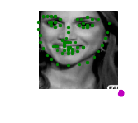

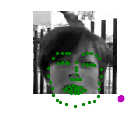

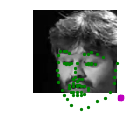

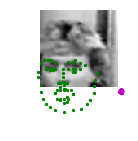

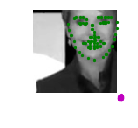

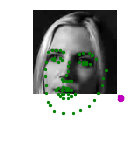

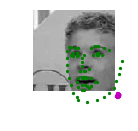

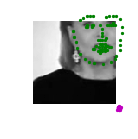

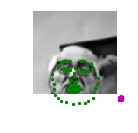

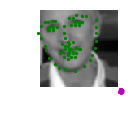

In [11]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = to_cpu_tensor(image).numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = to_cpu_tensor(test_outputs[i].data)
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [12]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters())


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [13]:
from matplotlib.pyplot import figure

def plot_loss_over_epoch(data):
    figure(figsize=(15, 8))
    plt.title("Loss Over Epoch")
    plt.scatter(data[:,0], data[:,2], c='b', label="Validation Loss")
    plt.plot(data[:,0], data[:,2], c='b')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    x_ticks = np.arange(min(data[:,0]), max(data[:,0])+1, 50)
    print(x_ticks)
    plt.xticks(x_ticks)
    plt.legend()
    plt.grid(True)
    plt.show()

def process_data_for_model(data):
    images = data['image']
    key_pts = data['keypoints']

    # flatten pts
    key_pts = key_pts.view(key_pts.size(0), -1)

    # convert variables to floats for regression loss
    key_pts = to_cuda_tensor(key_pts.type(torch.FloatTensor))
    images = to_cuda_tensor(images.type(torch.FloatTensor))
    
    return images, key_pts

def train_net(n_epochs):

    
    loss_data = np.arange(n_epochs * 3, dtype=np.float).reshape(n_epochs, 3)
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        # prepare the net for training
        net.train()
        
        running_loss = 0.0
                
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images, key_pts = process_data_for_model(data)
            
            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

        net.eval()
        running_val_loss = 0.0
        for batch_i, data in enumerate(validation_loader):
            images_val, key_pts_val = process_data_for_model(data)
            output_pts = net(images_val)
            loss = criterion(output_pts, key_pts_val)
            running_val_loss += loss.item()
            
            
        training_loss_average = running_loss/len(train_loader)
        validation_loss_average = running_val_loss/len(validation_loader)
        
        loss_data[epoch][0] = epoch + 1
        loss_data[epoch][1] = training_loss_average
        loss_data[epoch][2] = validation_loss_average
        
        print('Epoch: {}, Avg. Training Loss: {}, Avg. Validation Loss: {}'.format(epoch + 1,training_loss_average, validation_loss_average))
        
       
    plot_loss_over_epoch(loss_data)

    print('Finished Training')


Epoch: 1, Batch: 10, Avg. Loss: 0.3062179937958717
Epoch: 1, Batch: 20, Avg. Loss: 0.1473540857434273
Epoch: 1, Avg. Training Loss: 0.02402289628982544, Avg. Validation Loss: 0.10456919340150697
Epoch: 2, Batch: 10, Avg. Loss: 0.1211513638496399
Epoch: 2, Batch: 20, Avg. Loss: 0.11039839684963226
Epoch: 2, Avg. Training Loss: 0.020072479844093324, Avg. Validation Loss: 0.11780490577220917
Epoch: 3, Batch: 10, Avg. Loss: 0.10600753501057625
Epoch: 3, Batch: 20, Avg. Loss: 0.10285739153623581
Epoch: 3, Avg. Training Loss: 0.019730296432971955, Avg. Validation Loss: 0.11050171234777996
Epoch: 4, Batch: 10, Avg. Loss: 0.09962058067321777
Epoch: 4, Batch: 20, Avg. Loss: 0.09608805030584336
Epoch: 4, Avg. Training Loss: 0.018415687680244444, Avg. Validation Loss: 0.09516059138945171
Epoch: 5, Batch: 10, Avg. Loss: 0.09283603578805924
Epoch: 5, Batch: 20, Avg. Loss: 0.09228769391775131
Epoch: 5, Avg. Training Loss: 0.016467287838459015, Avg. Validation Loss: 0.08587087935635022
Epoch: 6, Batc

Epoch: 42, Batch: 10, Avg. Loss: 0.025084284506738184
Epoch: 42, Batch: 20, Avg. Loss: 0.02499971129000187
Epoch: 42, Avg. Training Loss: 0.004959359243512154, Avg. Validation Loss: 0.01868560103965657
Epoch: 43, Batch: 10, Avg. Loss: 0.0251566668972373
Epoch: 43, Batch: 20, Avg. Loss: 0.02499941159039736
Epoch: 43, Avg. Training Loss: 0.0049379560351371764, Avg. Validation Loss: 0.016331332775631122
Epoch: 44, Batch: 10, Avg. Loss: 0.02438243869692087
Epoch: 44, Batch: 20, Avg. Loss: 0.025235052965581418
Epoch: 44, Avg. Training Loss: 0.004423298686742782, Avg. Validation Loss: 0.016302891275180236
Epoch: 45, Batch: 10, Avg. Loss: 0.02779086958616972
Epoch: 45, Batch: 20, Avg. Loss: 0.023634782060980797
Epoch: 45, Avg. Training Loss: 0.004214321523904801, Avg. Validation Loss: 0.019290762926851
Epoch: 46, Batch: 10, Avg. Loss: 0.023777695186436177
Epoch: 46, Batch: 20, Avg. Loss: 0.024964309111237527
Epoch: 46, Avg. Training Loss: 0.0036168549209833144, Avg. Validation Loss: 0.0146018

Epoch: 82, Avg. Training Loss: 0.003626431077718735, Avg. Validation Loss: 0.013056173401751688
Epoch: 83, Batch: 10, Avg. Loss: 0.018381597753614188
Epoch: 83, Batch: 20, Avg. Loss: 0.0176898661069572
Epoch: 83, Avg. Training Loss: 0.0035923335701227186, Avg. Validation Loss: 0.011143561173230409
Epoch: 84, Batch: 10, Avg. Loss: 0.019345386419445276
Epoch: 84, Batch: 20, Avg. Loss: 0.01894109370186925
Epoch: 84, Avg. Training Loss: 0.004181081242859363, Avg. Validation Loss: 0.013169716338493995
Epoch: 85, Batch: 10, Avg. Loss: 0.017646238766610624
Epoch: 85, Batch: 20, Avg. Loss: 0.019727176707237958
Epoch: 85, Avg. Training Loss: 0.003867989405989647, Avg. Validation Loss: 0.011802480409720114
Epoch: 86, Batch: 10, Avg. Loss: 0.019060533866286276
Epoch: 86, Batch: 20, Avg. Loss: 0.01941639743745327
Epoch: 86, Avg. Training Loss: 0.003428668528795242, Avg. Validation Loss: 0.010797836950847082
Epoch: 87, Batch: 10, Avg. Loss: 0.02000956442207098
Epoch: 87, Batch: 20, Avg. Loss: 0.018

Epoch: 122, Avg. Training Loss: 0.0027600519731640818, Avg. Validation Loss: 0.010770666559359857
Epoch: 123, Batch: 10, Avg. Loss: 0.01643350599333644
Epoch: 123, Batch: 20, Avg. Loss: 0.016031801607459782
Epoch: 123, Avg. Training Loss: 0.003109978623688221, Avg. Validation Loss: 0.011133934158299651
Epoch: 124, Batch: 10, Avg. Loss: 0.015030169673264027
Epoch: 124, Batch: 20, Avg. Loss: 0.015820618811994792
Epoch: 124, Avg. Training Loss: 0.004221253171563149, Avg. Validation Loss: 0.00979332605909024
Epoch: 125, Batch: 10, Avg. Loss: 0.01719479002058506
Epoch: 125, Batch: 20, Avg. Loss: 0.01645933957770467
Epoch: 125, Avg. Training Loss: 0.0027651358768343926, Avg. Validation Loss: 0.012709440437278577
Epoch: 126, Batch: 10, Avg. Loss: 0.01584262177348137
Epoch: 126, Batch: 20, Avg. Loss: 0.01471646660938859
Epoch: 126, Avg. Training Loss: 0.002901790104806423, Avg. Validation Loss: 0.01286268745149885
Epoch: 127, Batch: 10, Avg. Loss: 0.017264240235090256
Epoch: 127, Batch: 20, Av

Epoch: 162, Batch: 20, Avg. Loss: 0.014959561545401812
Epoch: 162, Avg. Training Loss: 0.0028234626352787017, Avg. Validation Loss: 0.009737365466675588
Epoch: 163, Batch: 10, Avg. Loss: 0.01694060005247593
Epoch: 163, Batch: 20, Avg. Loss: 0.01516467034816742
Epoch: 163, Avg. Training Loss: 0.00257702250033617, Avg. Validation Loss: 0.008917182870209216
Epoch: 164, Batch: 10, Avg. Loss: 0.013858177699148655
Epoch: 164, Batch: 20, Avg. Loss: 0.012882348522543908
Epoch: 164, Avg. Training Loss: 0.0019918926060199737, Avg. Validation Loss: 0.01004189487014498
Epoch: 165, Batch: 10, Avg. Loss: 0.016992232389748098
Epoch: 165, Batch: 20, Avg. Loss: 0.016053541284054517
Epoch: 165, Avg. Training Loss: 0.003258255198597908, Avg. Validation Loss: 0.009638429087187563
Epoch: 166, Batch: 10, Avg. Loss: 0.016016468685120345
Epoch: 166, Batch: 20, Avg. Loss: 0.015598372649401426
Epoch: 166, Avg. Training Loss: 0.002787010297179222, Avg. Validation Loss: 0.012437452688547117
Epoch: 167, Batch: 10,

Epoch: 202, Batch: 10, Avg. Loss: 0.016246533766388894
Epoch: 202, Batch: 20, Avg. Loss: 0.013525000307708979
Epoch: 202, Avg. Training Loss: 0.0031374791637063027, Avg. Validation Loss: 0.010022578002618892
Epoch: 203, Batch: 10, Avg. Loss: 0.015344446245580911
Epoch: 203, Batch: 20, Avg. Loss: 0.016350253857672213
Epoch: 203, Avg. Training Loss: 0.003212504293769598, Avg. Validation Loss: 0.010762753643627677
Epoch: 204, Batch: 10, Avg. Loss: 0.014244749024510384
Epoch: 204, Batch: 20, Avg. Loss: 0.012909590173512698
Epoch: 204, Avg. Training Loss: 0.0032312674820423127, Avg. Validation Loss: 0.00821015327902777
Epoch: 205, Batch: 10, Avg. Loss: 0.014225059747695923
Epoch: 205, Batch: 20, Avg. Loss: 0.014012593496590852
Epoch: 205, Avg. Training Loss: 0.002674662321805954, Avg. Validation Loss: 0.007915914970050964
Epoch: 206, Batch: 10, Avg. Loss: 0.013905935268849135
Epoch: 206, Batch: 20, Avg. Loss: 0.014090073574334384
Epoch: 206, Avg. Training Loss: 0.0023207618668675423, Avg. V

Epoch: 242, Batch: 10, Avg. Loss: 0.014421694539487362
Epoch: 242, Batch: 20, Avg. Loss: 0.013717317581176757
Epoch: 242, Avg. Training Loss: 0.0020148956030607225, Avg. Validation Loss: 0.007288438846756305
Epoch: 243, Batch: 10, Avg. Loss: 0.012285403441637754
Epoch: 243, Batch: 20, Avg. Loss: 0.013850746490061284
Epoch: 243, Avg. Training Loss: 0.0019941996410489083, Avg. Validation Loss: 0.009577386693230697
Epoch: 244, Batch: 10, Avg. Loss: 0.013691162411123513
Epoch: 244, Batch: 20, Avg. Loss: 0.01089217932894826
Epoch: 244, Avg. Training Loss: 0.0028273580595850945, Avg. Validation Loss: 0.007470962205635649
Epoch: 245, Batch: 10, Avg. Loss: 0.01316892048344016
Epoch: 245, Batch: 20, Avg. Loss: 0.013550211023539305
Epoch: 245, Avg. Training Loss: 0.002692246958613396, Avg. Validation Loss: 0.007804239980344262
Epoch: 246, Batch: 10, Avg. Loss: 0.014568790886551141
Epoch: 246, Batch: 20, Avg. Loss: 0.013204800523817539
Epoch: 246, Avg. Training Loss: 0.002259264066815376, Avg. Va

Epoch: 282, Batch: 10, Avg. Loss: 0.011720801424235105
Epoch: 282, Batch: 20, Avg. Loss: 0.012313424050807953
Epoch: 282, Avg. Training Loss: 0.0020097162574529647, Avg. Validation Loss: 0.005896491144916841
Epoch: 283, Batch: 10, Avg. Loss: 0.012732201162725687
Epoch: 283, Batch: 20, Avg. Loss: 0.012022802885621787
Epoch: 283, Avg. Training Loss: 0.0020169246196746825, Avg. Validation Loss: 0.006093369530779975
Epoch: 284, Batch: 10, Avg. Loss: 0.015017839707434177
Epoch: 284, Batch: 20, Avg. Loss: 0.012467567343264818
Epoch: 284, Avg. Training Loss: 0.002637646086513996, Avg. Validation Loss: 0.007182456799117582
Epoch: 285, Batch: 10, Avg. Loss: 0.012891645729541778
Epoch: 285, Batch: 20, Avg. Loss: 0.011927600856870413
Epoch: 285, Avg. Training Loss: 0.0025194642320275308, Avg. Validation Loss: 0.007908929877781442
Epoch: 286, Batch: 10, Avg. Loss: 0.012324841879308223
Epoch: 286, Batch: 20, Avg. Loss: 0.011609132867306471
Epoch: 286, Avg. Training Loss: 0.0020905710384249688, Avg.

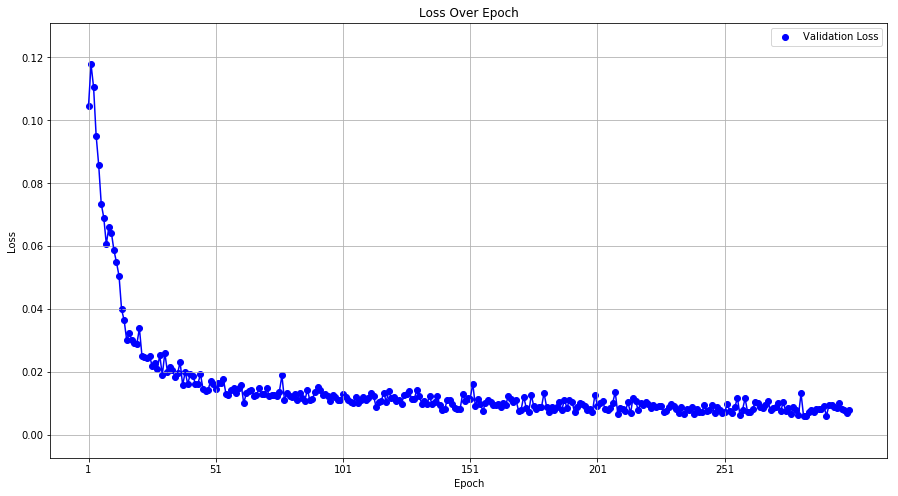

Finished Training


In [14]:
# train your network
n_epochs = 300 # start small, and increase when you've decided on your model structure and hyperparams

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
net.apply(init_weights)

train_net(n_epochs)

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [20]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

0
Training
Done
Returning
torch.Size([10, 1, 96, 96])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


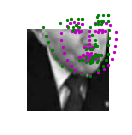

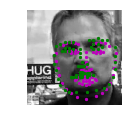

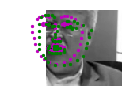

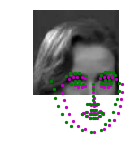

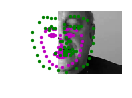

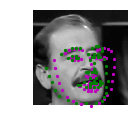

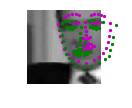

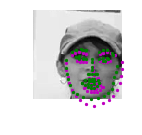

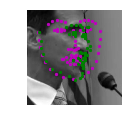

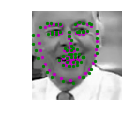

In [21]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [22]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = '300_epoch_namishnet_model.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 

Loss Function: SmoothL1Loss was chosen as this can be used for regression based problems. 

Optimization: Adam was chosen as an alternative to SGD. According to the authors of Adam, it's computationally efficient with little memory requirements, making it suitable for Computer Vision problems that typically have a large number of inputs.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**:

Initially I started with a single convolutional layer and a single output layer to see how that would work (poorly as it turned out).

Over time I added additional convolutional layers to see if it would improve accuracy, including a dropout layer just on the fully connected layers at the end. 

In the end, I followed the paper provided, and implemented NamishNet, which gave far better results than anything I was experimenting with.

Their archicture has 4 convolutional layers, incrementing features in powers of 2 (for computational performance reasons), where each convolutional layer has an ELU activation layer, a MaxPool2D layer to half the size of the input, and a dropout layer incrementing in p by steps of 0.1. The drop out layers continue (still steps of 0.1) for the fully connected layers.

In addition, I experimented with different scales of cropping for the input into the network. I found that by introducing a more extreme crop on the image (where only a portion of the facial features were visible), it performed far better in Notebook 3, as the Haar Cascade classifier crops out features like the chin. Without that form of transformation, the "chin" part of the key points were being aligned with the bottom of the lips.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**:

Epoch size was chosen by plotting a validation test set over time to see where the learning rate started to go flat. I saw the curve really begin to flatten between the 250th and 300th epoch, which matches to observation in NamishNet.

An alternative to this would have been to implement something like early stopping, using the validation set to do this automatically.

Batch size was chosen based on advice in the provided paper, and limitations on my GPU. For computational performance, powers of 2 were used, and I settled on 128, same as the NamishNet paper.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.00595527  0.24407771  0.11178518  0.42097357]
 [-0.20791449 -0.06627662  0.13180394 -0.13417684]
 [-0.11326965 -0.13291493 -0.04672059 -0.19586311]
 [-0.04782438 -0.23073043 -0.24279474  0.11095584]]
(4, 4)


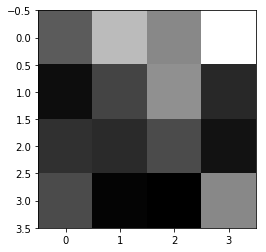

In [23]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = to_cpu_tensor(weights1).numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

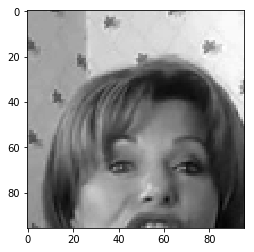

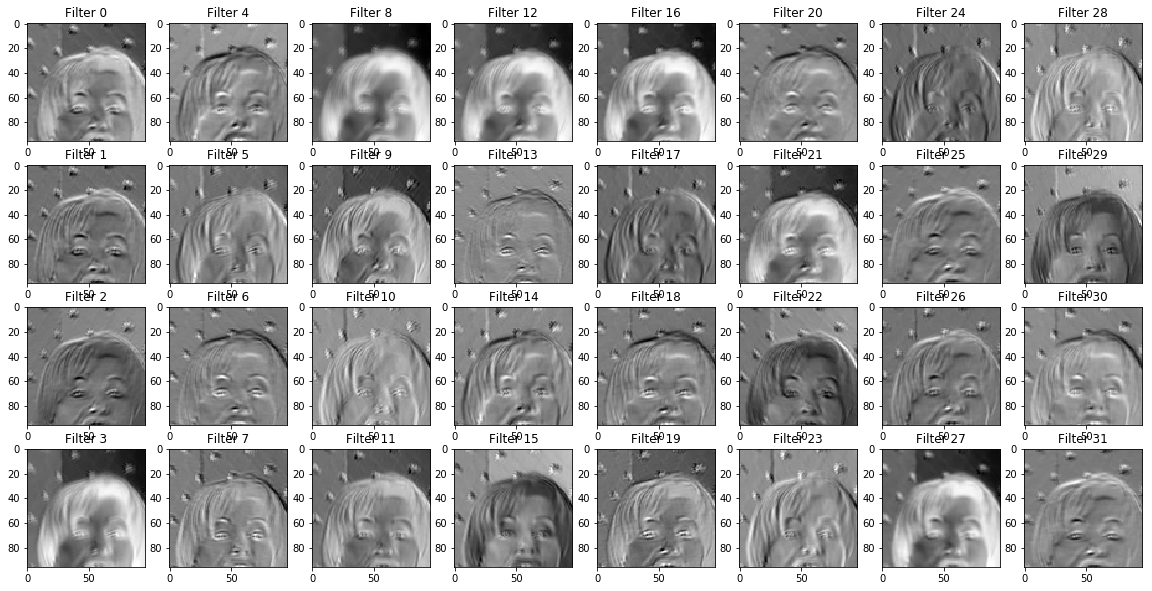

In [30]:
import cv2

#image_index = np.random.randint(0, len(test_dataset))
image_index = 10
image = test_dataset[image_index]
image = image['image'].numpy()
image = np.transpose(image, (1, 2, 0))
image = image.reshape(image.shape[0], image.shape[1])

plt.imshow(image, cmap='gray')

# Loop through and apply each filter to the image

f, sub_plts = plt.subplots(4, 8, figsize=(20,10))
plt.imshow(image, cmap='gray')
filter_index = 0
for i in range(0, 8):
    for j in range(0, 4):
        sub_plts[j][i].set_title('Filter %s' % filter_index)
        filtered_image = cv2.filter2D(image, -1, w[filter_index][0])
        sub_plts[j][i].imshow(filtered_image, cmap='gray')
        filter_index += 1




### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: 
Filter 8 appears to blur the image to reduce noise.

Filter 14 appears to be a vertical filter, as it emphasies the hair outline.

Filter 16 appears to be a horizontal filter, as it highlights lines such as the lips, eyes, and eyebrows.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!